In [2]:
import os
import glob
import pickle
import gzip
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
#tf.enable_eager_execution()

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
from matplotlib import pyplot as plt
%matplotlib inline
from werdich_cfr.tfutils.TFRprovider import DatasetProvider
from werdich_cfr.tfutils.Modeltrainer import VideoTrainer
from werdich_cfr.utils.visuals import ImageSliceViewer3D

TensorFlow Version: 2.1.0


### Recover data from TFRecords: look at the postprocessed images ###

In [3]:
# Directories and files
cfr_data_root = os.path.normpath('/mnt/obi0/andreas/data/cfr')
meta_date = '200304'
tfr_dir = os.path.join(cfr_data_root, 'tfr_'+meta_date)
meta_dir = os.path.join(cfr_data_root, 'metadata_'+meta_date)

# TFR file
tfr_file = os.path.join(tfr_dir, 'cfr_resized75_a4c_train_200304_0.tfrecords')
parquet_file = os.path.join(tfr_dir, 'cfr_resized75_a4c_train_200304_0.parquet')

# Load df 
df = pd.read_parquet(parquet_file)
df.head(50)

,study,mrn,echo_study_date,mrnstudyid,days_post_cfr,cfr_study_date,petmrn_identifier,post-2018,myocardial_perfusion,global_cfr_calc,unaffected_cfr,rest_mbf_unaff,stress_mbf_unaff,num_unaffected_segs,rest_global_mbf,stress_global_mbf,filename,dir,datetime,fileid,institution,model,manufacturer,index,frame_time,number_of_frames,heart_rate,deltaX,deltaY,a2c,a2c_laocc,a2c_lvocc_s,a3c,a3c_laocc,a3c_lvocc_s,a4c,a4c_far,a4c_laocc,a4c_lvocc_s,a4c_rv,a4c_rv_laocc,a5c,apex,other,plax_far,plax_lac,plax_laz,plax_laz_ao,plax_plax,psax_avz,psax_az,psax_mv,psax_pap,rvinf,subcostal,suprasternal,max_view,mode,rate,im_array_shape
54538,4907b1bf3b33766b_4903a584a1b9a5737afe76d98d69,24867491,2011-03-22,2262,302,2010-05-24,24867491_2010-05-24,0,normal,2.437252,2.450845,0.790412,1.937176,17,0.757,1.845,4907b1bf3b33766b_4903a584a1b9a5737afe76d98d69_...,/mnt/obi0/phi/echo/npyFiles/BWH/4907/4907b1bf3...,2011-03-22 08:06:27,4907b1bf3b33766b_4903a584a1b9a5737afe76d98d69_...,BWH,iE33,Philips Medical Systems,0.0,33.333000,129.0,52.0,0.037483,0.037483,6.612794e-14,1.837714e-11,1.883813e-13,1.213770e-12,4.035315e-15,1.122545e-12,1.000000,3.078564e-13,6.936902e-15,5.975178e-13,1.128219e-13,1.312490e-13,8.505656e-16,3.279004e-12,3.921602e-16,3.154265e-12,2.399879e-14,2.179827e-11,4.844475e-15,7.093673e-12,1.226187e-10,5.046560e-13,7.947762e-13,1.796938e-12,3.000783e-15,3.737805e-19,1.314921e-16,a4c,train,30.0,"[169, 225, 40]"
96799,4906a0b6cbb1f945_4903a58792a07bfce0b19c9eeea2,25132044,2012-11-19,2303,-2,2012-11-21,25132044_2012-11-21,0,abnormal,1.329975,1.364016,0.824444,1.124556,9,0.794,1.056,4906a0b6cbb1f945_4903a58792a07bfce0b19c9eeea2_...,/mnt/obi0/phi/echo/npyFiles/BWH/4906/4906a0b6c...,2012-11-19 08:19:14,4906a0b6cbb1f945_4903a58792a07bfce0b19c9eeea2_...,BWH,Vivid S6,GEMS Ultrasound,0.0,33.550724,93.0,59.0,0.043165,0.043165,2.692061e-07,4.700260e-06,6.691415e-08,1.427393e-01,8.409672e-05,3.463385e-06,0.853535,1.943321e-07,1.056534e-03,3.310900e-07,2.298310e-03,2.954689e-07,4.571272e-06,5.513391e-06,1.074721e-08,2.505709e-07,6.072935e-05,3.855222e-07,6.210845e-09,1.552717e-07,3.106840e-07,2.133884e-06,1.033491e-06,1.975696e-04,4.156411e-06,3.346775e-10,6.949776e-07,a4c,train,29.8,"[137, 206, 40]"
79121,4a113f49051bc797_4903a582ec75199612daf6e83fc9,17196445,2017-04-17,1439,97,2017-01-10,17196445_2017-01-10,0,abnormal,1.542190,1.955744,0.713646,1.395709,2,0.557,0.859,4a113f49051bc797_4903a582ec75199612daf6e83fc9_...,/mnt/obi0/phi/echo/npyFiles/BWH/4a11/4a113f490...,2017-04-17 13:45:04,4a113f49051bc797_4903a582ec75199612daf6e83fc9_...,BWH,Affiniti 70C,Philips Medical Systems,0.0,33.333000,91.0,73.0,0.038876,0.038876,3.002488e-09,2.484388e-03,5.355904e-07,1.337885e-05,1.133307e-07,1.419652e-07,0.951439,1.563293e-05,3.267876e-04,9.521148e-08,1.185393e-07,7.350220e-08,4.513383e-02,4.170252e-09,3.680864e-10,5.204435e-07,5.191299e-05,8.820310e-07,1.003978e-07,1.729242e-09,4.858125e-08,1.871231e-05,3.679765e-08,5.110189e-04,1.518274e-06,2.123692e-10,9.324112e-07,a4c,train,30.0,"[175, 233, 40]"
73575,4b78dd4d58317852_4903a44b3308901ab47790432487,3825999,2008-12-10,361,-54,2009-02-02,3825999_2009-02-02,0,normal,2.876190,2.800407,0.983471,2.754118,17,0.945,2.718,4b78dd4d58317852_4903a44b3308901ab47790432487_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b78/4b78dd4d5...,2008-12-10 08:37:42,4b78dd4d58317852_4903a44b3308901ab47790432487_...,BWH,iE33,Philips Medical Systems,0.0,33.333000,91.0,72.0,0.041843,0.041843,9.841627e-08,1.511873e-04,7.069168e-10,2.002617e-10,1.416708e-10,1.383911e-11,0.999840,2.434900e-08,2.996917e-11,2.206353e-10,4.894312e-08,2.784212e-10,3.585469e-09,4.675600e-10,8.183748e-11,1.842880e-09,1.329066e-10,6.740007e-10,6.733829e-13,1.838382e-10,3.827696e-10,8.709857e-06,7.885756e-11,1.658413e-08,4.200977e-10,2.650209e-11,4.258308e-11,a4c,train,30.0,"[188, 251, 40]"
53069,4a1530bd9757b1b1_4903a44b32e5a686f3bba075308e,13604541,2008-09-29,1135,7,2008-09-22,13604541_2008-09-22,0,normal,2.997089,2.923122,0.696294,2.035353,17,0.687,2.059,4a1530bd9757b1b1_4903a44b

In [4]:
df.columns

Index(['study', 'mrn', 'echo_study_date', 'mrnstudyid', 'days_post_cfr', 'cfr_study_date', 'petmrn_identifier', 'post-2018', 'myocardial_perfusion', 'global_cfr_calc', 'unaffected_cfr', 'rest_mbf_unaff', 'stress_mbf_unaff', 'num_unaffected_segs', 'rest_global_mbf', 'stress_global_mbf', 'filename', 'dir', 'datetime', 'fileid', 'institution', 'model', 'manufacturer', 'index', 'frame_time', 'number_of_frames', 'heart_rate', 'deltaX', 'deltaY', 'a2c', 'a2c_laocc', 'a2c_lvocc_s', 'a3c', 'a3c_laocc', 'a3c_lvocc_s', 'a4c', 'a4c_far', 'a4c_laocc', 'a4c_lvocc_s', 'a4c_rv', 'a4c_rv_laocc', 'a5c', 'apex', 'other', 'plax_far', 'plax_lac', 'plax_laz', 'plax_laz_ao', 'plax_plax', 'psax_avz', 'psax_az', 'psax_mv', 'psax_pap', 'rvinf', 'subcostal', 'suprasternal', 'max_view', 'mode', 'rate', 'im_array_shape'], dtype='object')

### Percentile thresholds for classification and image sizes ###

In [11]:
test_files

['/mnt/obi0/andreas/data/cfr/tfr_200304/cfr_resized75_a4c_test_200304_6.parquet',
 '/mnt/obi0/andreas/data/cfr/tfr_200304/cfr_resized75_a4c_test_200304_2.parquet',
 '/mnt/obi0/andreas/data/cfr/tfr_200304/cfr_resized75_a4c_test_200304_7.parquet',
 '/mnt/obi0/andreas/data/cfr/tfr_200304/cfr_resized75_a4c_test_200304_3.parquet',
 '/mnt/obi0/andreas/data/cfr/tfr_200304/cfr_resized75_a4c_test_200304_5.parquet',
 '/mnt/obi0/andreas/data/cfr/tfr_200304/cfr_resized75_a4c_test_200304_1.parquet',
 '/mnt/obi0/andreas/data/cfr/tfr_200304/cfr_resized75_a4c_test_200304_4.parquet',
 '/mnt/obi0/andreas/data/cfr/tfr_200304/cfr_resized75_a4c_test_200304_0.parquet']

In [12]:
# TFR .parquet data files
train_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized75_a4c_train_200304_*.parquet'))
eval_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized75_a4c_eval_200304_*.parquet'))
test_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized75_a4c_test_200304_*.parquet'))

train_df = pd.concat([pd.read_parquet(file) for file in train_files])
eval_df = pd.concat([pd.read_parquet(file) for file in eval_files])
test_df = pd.concat([pd.read_parquet(file) for file in test_files])
dset = pd.concat([train_df, eval_df, test_df], axis = 0, ignore_index=True).reset_index(drop=True)
print(dset.shape)

print('Size of cfr table:', dset.shape)
cfr_array = dset.rest_mbf_unaff.values
p_list = [np.round(np.percentile(cfr_array, p), decimals = 3) for p in (25, 50, 75)]
print('Percentile boundaries:', p_list)

percentile_list = p_list
def cfr_p_label(cfr_value):
    return np.digitize(cfr_value, bins = percentile_list)
# Setting the threshold, check the number of positives and negatives
df['labelp'] = df['rest_mbf_unaff'].apply(cfr_p_label)
print(df.labelp.iloc[0:10].values)

(4110, 60)
Size of cfr table: (4110, 60)
Percentile boundaries: [0.688, 0.865, 1.139]
[1 1 1 2 1 1 3 1 2 2]


In [25]:
def cfr_label(cfr_value):
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    
    for p in range(1, len(percentile_list)):
        
        if (cfr_value >= percentile_list[p-1]) & (cfr_value < percentile_list[p]):
            label = p
    
    return label

df['label'] = df['unaffected_cfr'].apply(cfr_label)
print(df.label.iloc[0:10].values)

[0 1 1 2 1 0 0 2 3 3]


In [26]:
label_list = sorted(df.label.unique())
print('Unique labels:', label_list)
df.head(20)
# Number of samples in each group
samples = [df[df.label == l].shape[0] for l in label_list]
for l in label_list:
    print('Label:', l, 'samples:', samples[l])

Unique labels: [0, 1, 2, 3]
Label: 0 samples: 377
Label: 1 samples: 370
Label: 2 samples: 351
Label: 3 samples: 393


### TFR extraction and postprocessing ###

In [3]:
n_frames = 40
cfr_boundaries = (1.232, 1.556, 2.05)
output_height = 299
output_width = 299
augment = True
#im_scale_factor=0.5642
im_scale_factor = 1.177
#im_scale_factor = 3
batch_size = 8
model_output = 'rest_mbf'

In [4]:
@tf.function
def cfr_label(cfr_value):
    ''' classification label for cfr value '''
    percentile_list = cfr_boundaries
    label = 0
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    for p in range(1, len(percentile_list)):
        if (cfr_value >= percentile_list[p - 1]) & (cfr_value < percentile_list[p]):
            label = p
    return tf.one_hot(label, depth = len(percentile_list)+1)

In [5]:
def parse(serialized):

    example = {'image': tf.io.FixedLenFeature([], tf.string),
               'shape': tf.io.FixedLenFeature([], tf.string),
               'cfr': tf.io.FixedLenFeature([], tf.float32),
               'rest_mbf': tf.io.FixedLenFeature([], tf.float32),
               'stress_mbf': tf.io.FixedLenFeature([], tf.float32),
               'record': tf.io.FixedLenFeature([], tf.int64)}

    # Extract example from the data record
    example = tf.io.parse_single_example(serialized, example)

    # Convert image to tensor and shape it
    image_raw = tf.io.decode_raw(example['image'], tf.uint16)
    shape = tf.io.decode_raw(example['shape'], tf.uint16)
    shape = tf.cast(shape, tf.int32) # tf.reshape requires int16 or int32 types
    image = tf.reshape(image_raw, shape)

    # Here, we have recovered the original shape of the images.
    # Now we need to process them.

    cfr = example['cfr']
    rest_mbf = example['rest_mbf']
    stress_mbf = example['stress_mbf']
    record = example['record']

    # Create output tuple

    video_output = {'video': process_image(image, shape)}

    if model_output == 'cfr':
        score_output = {'score_output': cfr}
    elif model_output == 'rest_mbf':
        score_output = {'score_output': rest_mbf}
    elif model_output == 'stress_mbf':
        score_output = {'score_output': stress_mbf}
    else:
        # Enable all outputs for testing.
        score_output = {'class_output': cfr_label(cfr),
                        'cfr_output': cfr,
                        'mbf_output': rest_mbf,
                        'record': record}

    return (video_output, score_output)

In [6]:
def augment_image(image):
        
    # maximum rotation angle in degrees
    max_ang_deg = 10
    max_ang = np.pi/180*max_ang_deg
    
    # Random rotation
    image = tfa.image.rotate(image, tf.random.uniform(shape=[], 
                                                      minval=-max_ang, maxval=max_ang, 
                                                      dtype=tf.float32), 
                             interpolation='NEAREST')
    
    # Brightness, contrast
    image = tf.image.random_brightness(image, 0.5)
    image = tf.image.random_contrast(image, 0.7, 2.5)
    
    return image
    
def process_image(image, shape):

    # original shape is [height, width, frames] -> [frames, height, width, 1]
    # If there is no scale-factor, the images will be resized to fit
    image = tf.reshape(image, shape=shape)
    image = tf.transpose(image, perm=[2, 0, 1])
    image = tf.expand_dims(image, axis=-1)

    if im_scale_factor is None:
        image = tf.image.resize_with_pad(image,
                                         target_height=output_height,
                                         target_width=output_width)
    else:
        # Re-size the image with a single scale factor, then pad or crop to output_size
        im_size = tf.cast(tf.slice(shape, [0], [2]), dtype=tf.float32)
        new_im_size = tf.cast(tf.math.ceil(tf.math.scalar_mul(im_scale_factor, im_size)), tf.int32)
        image = tf.image.resize(image, size=new_im_size, antialias=True)
        # Crop or pad to the desired output size
        image = tf.image.resize_with_crop_or_pad(image,
                                                 target_height=output_height,
                                                 target_width=output_width)
    
    # Augment images
    if augment:
        image = augment_image(image)
    
    # Scale image to have mean 0 and variance 1
    image = tf.cast(image, tf.float32)
    image = tf.image.adjust_contrast(image, contrast_factor=5)
    output_image = tf.image.per_image_standardization(image)

    return output_image

In [7]:
dataset = tf.data.TFRecordDataset([tfr_file])

# Parse records
dataset = dataset.map(map_func=parse,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE).\
    cache().prefetch(tf.data.experimental.AUTOTUNE)

# Batch it up
dataset = dataset.batch(batch_size, drop_remainder=False)

# Prefetch
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [9]:
for out in dataset.take(1):
    output = out

# Output batch is a list of dictionaries [INPUT, OUTPUT]:
print('Input keys: ', output[0].keys())
print('Output keys:', output[1].keys())
image_batch = output[0]['video'].numpy()
print('Video batch shape:', image_batch.shape)
score_batch = output[1]['score_output'].numpy()
print('score_output shale:', score_batch.shape)
for image in image_batch:
    print('min {}, max {}'.format(np.amin(image), np.amax(image)))

Input keys:  dict_keys(['video'])
Output keys: dict_keys(['score_output'])
Video batch shape: (8, 40, 299, 299, 1)
score_output shale: (8,)
min -0.4272294342517853, max 8.989699363708496
min -0.34275829792022705, max 11.112221717834473
min -0.3471528887748718, max 15.06191349029541
min -0.49062371253967285, max 6.1805925369262695
min -0.4041762351989746, max 11.114198684692383
min -0.4870578944683075, max 8.196309089660645
min -0.45249879360198975, max 7.862017631530762
min -0.3134065866470337, max 9.553495407104492


Video batch shape: (8, 40, 299, 299, 1)


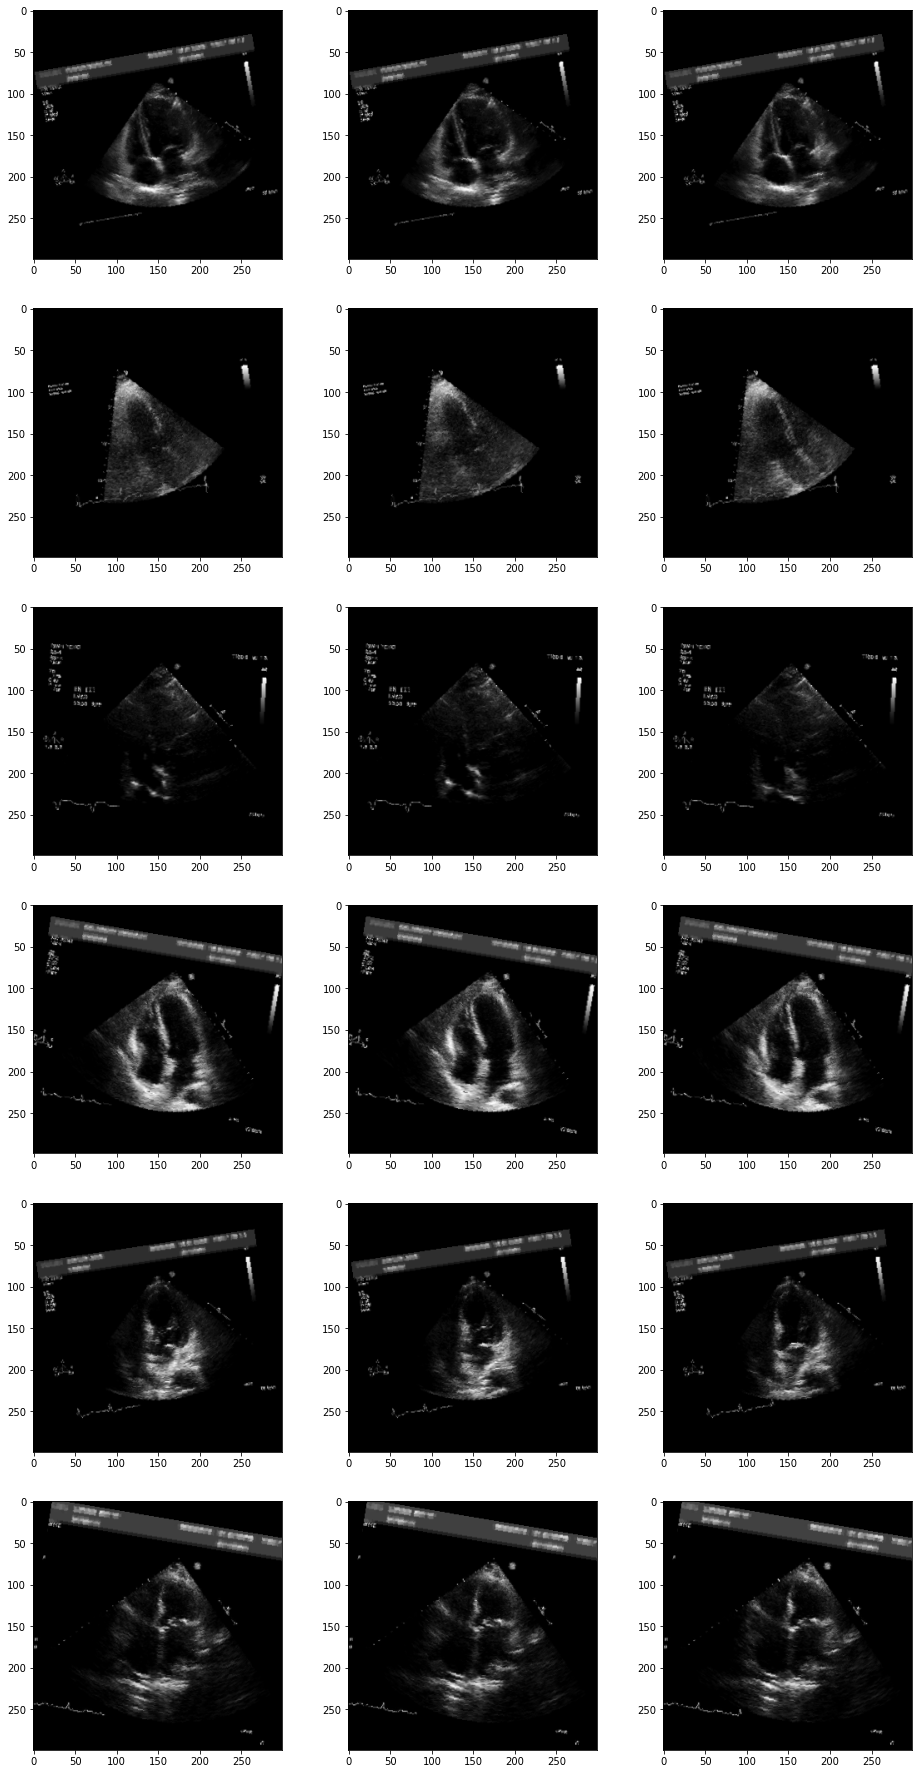

In [10]:
for out in dataset.take(1):
    output = out

# Output batch is a list of dictionaries [INPUT, OUTPUT]:
image_batch = output[0]['video'].numpy()
print('Video batch shape:', image_batch.shape)

# Show some images from the batch
#sample_idx = np.random.randint(batch_size, size=6)
sample_idx = np.arange(0, 6)
frame_idx = np.random.randint(n_frames, size=3)
fig, ax = plt.subplots(nrows=len(sample_idx), ncols=len(frame_idx), figsize = (16,32))

for row, sample in enumerate(sample_idx):
    for col, frame in enumerate(frame_idx):
        image = np.squeeze(image_batch[sample, frame, :, :, 0])
        ax[row, col].imshow(image, cmap = 'gray')

### Sample output from the DatasetProvider class ###

In [11]:
# Parameters
batch_size=16

# Dataset
dset_provider = DatasetProvider(output_height=299,
                                output_width=299,
                                im_scale_factor=1.177,
                                augment=True,
                                model_output='rest_mbf')


dset = dset_provider.make_batch([tfr_file], 
                                batch_size=batch_size,
                                shuffle=False,
                                buffer_n_batches=2,
                                repeat_count=1,
                                drop_remainder=True)

for out in dset.take(1):
    output = out
    
image_batch = output[0]['video'].numpy()

In [12]:
print(output[1]['score_output'].numpy())

[0.7904118  0.8244445  0.7136459  0.98347056 0.6962941  0.809875
 1.5607778  0.8107     1.0998889  0.865468   0.53482854 0.8472353
 1.3779411  0.8887084  0.93370587 1.2683333 ]


In [13]:
print(df.rest_mbf_unaff.values[0:16])

[0.79041176 0.82444446 0.71364585 0.98347059 0.69629412 0.80987504
 1.56077778 0.8107     1.09988889 0.86546805 0.53482854 0.84723529
 1.37794118 0.8887084  0.93370588 1.26833333]


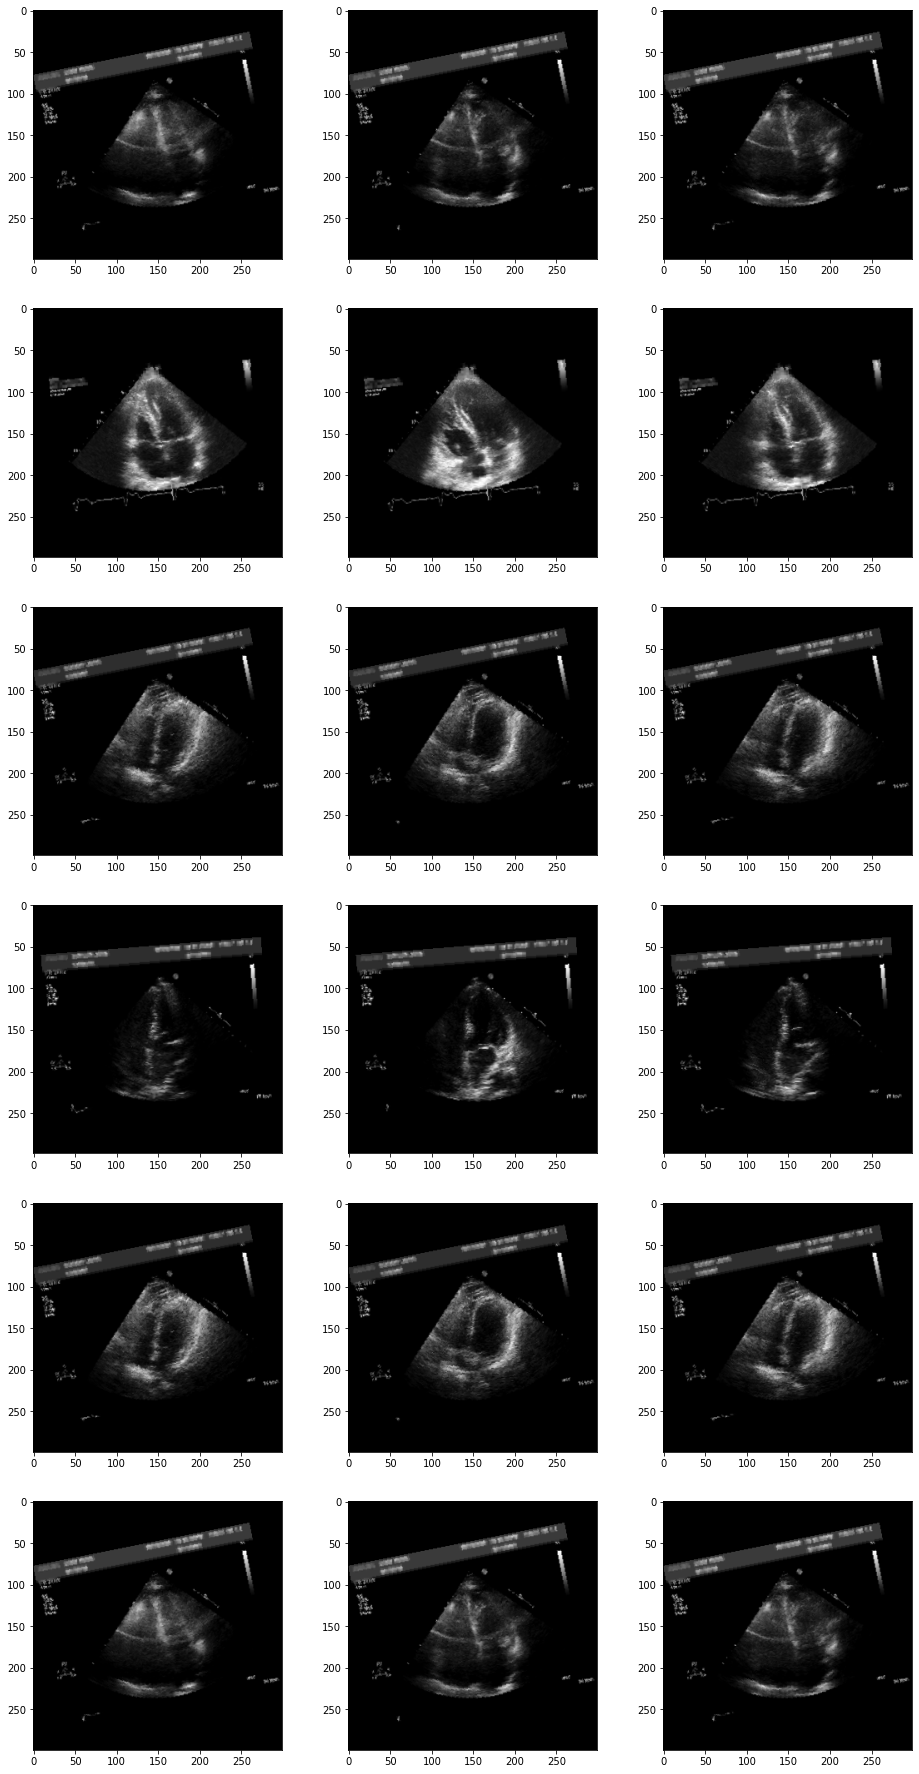

In [14]:
# Show some images from the batch
n_frames=40
sample_idx = np.random.randint(batch_size, size=6)
frame_idx = np.random.randint(n_frames, size=3)

fig, ax = plt.subplots(nrows=len(sample_idx), ncols=len(frame_idx), figsize = (16,32))

for row, sample in enumerate(sample_idx):
    for col, frame in enumerate(frame_idx):
        image = np.squeeze(image_batch[sample, frame, :, :, 0])
        ax[row, col].imshow(image, cmap = 'gray')